In [2]:
%matplotlib inline

import warnings
import gzip, pickle
import numpy as np
import matplotlib.pyplot as plt


warnings.filterwarnings(action='ignore')                    

In [3]:
plt.rcParams['figure.figsize'] = (10,8)

np.random.seed(0)

In [4]:
DATA_PATH = 'Data/mnist.pkl.gz'

with gzip.open(DATA_PATH, 'rb') as f:
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = pickle.load(f, encoding='latin')

print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


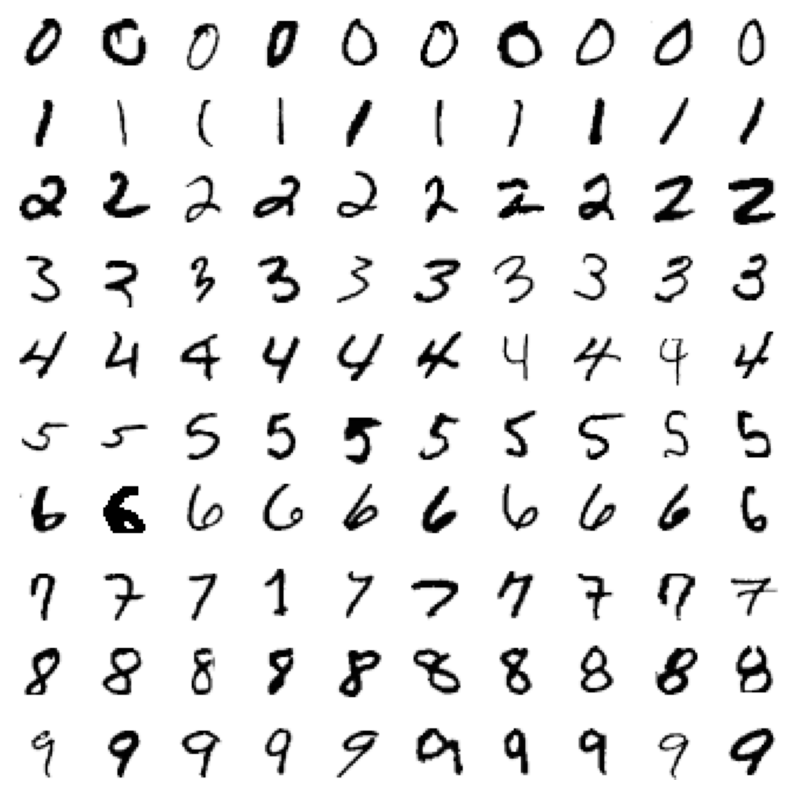

In [13]:
import matplotlib.pyplot as plt
import numpy as np

Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, Y in enumerate(Classes):
    # Get indices of samples for the current class
    indices = np.where(y_train == int(Y))[0]

    # Choose 10 random samples for the current class
    random_indices = np.random.choice(indices, 10, replace=False)

    for j, idx in enumerate(random_indices):
        ax = axs[i, j]
        ax.imshow(X_train[idx].reshape(28, 28), cmap=plt.cm.Greys)
        ax.grid(False)
        ax.axis('off')

plt.show()


### Normalization of data

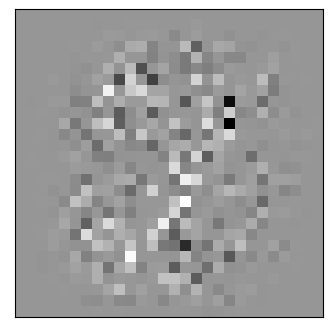

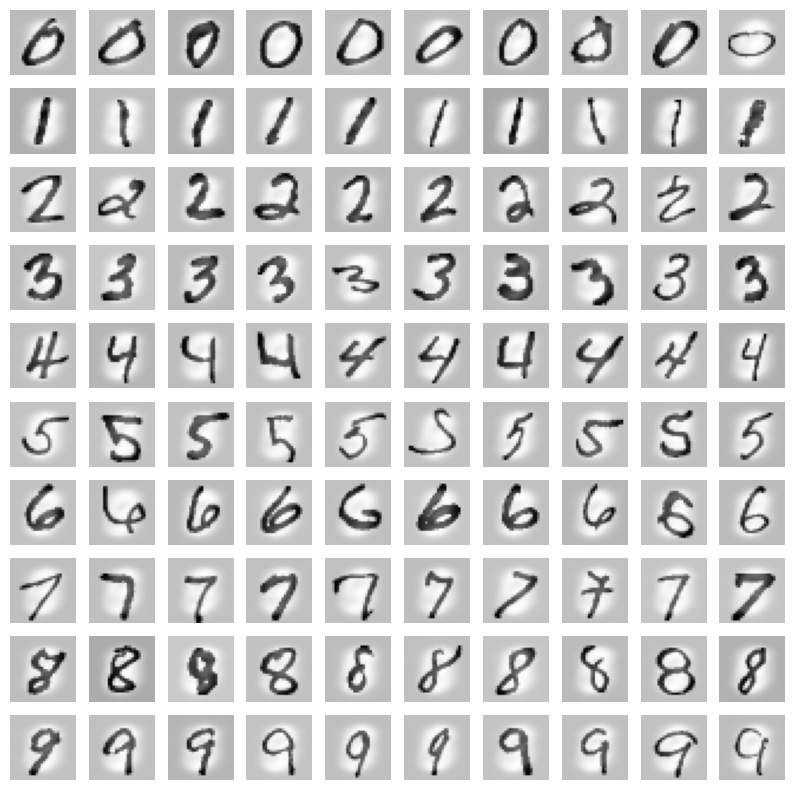

In [22]:
mu = np.mean(X_train, axis=0)
X_train -= mu
X_test -= mu
X_valid -= mu

plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28,28), cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.show()


Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, Y in enumerate(Classes):
    # Get indices of samples for the current class
    indices = np.where(y_train == int(Y))[0]

    # Choose 10 random samples for the current class
    random_indices = np.random.choice(indices, 10, replace=False)

    for j, idx in enumerate(random_indices):
        ax = axs[i, j]
        ax.imshow(X_train[idx].reshape(28, 28), cmap=plt.cm.Greys)
        ax.grid(False)
        ax.axis('off')

plt.show()

### Random weighting of W

In [38]:
def predict(W, b, X):
    scores = X @ W + b
    return np.argmax(scores, axis=1)

def accuracy(y_pred, y_true):
    return 100. * np.mean(y_pred == y_true)

c = 10                # number of classes 
n = X_train.shape[1]  # number of features

# init parameters randomly
W = 0.01 * np.random.randn(n, c)
b = np.zeros(c)

# predict classes and compute accuracy
y_pred = predict(W, b, X_train)
acc = accuracy(y_pred, y_train)  # this function is defined in utils.py
print("Accuracy = {:.2f}%".format(acc))

Accuracy = 12.47%


### Loss Minimization using Sotmax Function and Gradien Decent

In [32]:
def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) 
    ### This subtraction of the maximum value helps prevent numerical overflow or instability that can occur when taking the exponential of large numbers.
    ### It is a common practice to improve the numerical stability of the softmax function, 
    ## which is often used in the output layer of neural networks for multi-class classification problems.
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_loss(W, b, X_batch, y_batch, mode='train'):
    bs = X_batch.shape[0]  # batch size
    
    scores = X_batch @ W + b
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(bs), y_batch])) / bs
    
    if mode == 'test':
        return loss
    
    # compute gradients w.r.t scores
    dscores = np.copy(probs)
    dscores[range(bs), y_batch] -= 1.0
    dscores /= bs
    
    # compute gradients w.r.t W and b
    db = dscores.sum(axis=0)
    dW = X_batch.T @ dscores
    
    return loss, dW, db

In [55]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=32, 
                                alpha=0.01, lmbda=1e-4, num_epochs=100):
    
    m, n = X_train.shape
    num_batches = m % batch_size
    
    report = "Epoch {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
    
    # init parameters randomly
    W = np.random.randn(n, 10) * 0.001
    b = np.zeros((10,))
    
    for epoch in range(num_epochs):
        train_loss = 0.
        
        for batch in range(num_batches):
            
            # select a random mini-batch
            idx = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X_train[idx], y_train[idx]
            
            # compute loss and gradient
            loss, dW, db = softmax_loss(W, b, X_batch, y_batch)  # data loss
            loss += 0.5 * lmbda * np.sum(W ** 2)                 # regularization loss
            dW += lmbda * W
            
            train_loss += loss
            
            # update parameters            
            b = b - alpha * db
            W = W - alpha * dW
        
        # report stats after each epoch
        #train_loss /= num_batches        
        valid_loss = softmax_loss(W, b, X_valid, y_valid, mode='test')
        print(report.format(epoch+1, train_loss, valid_loss))
    
    return W, b

In [58]:
# hyper-parameters
alpha = 1e-1
lmbda = 1e-30
batch_size = 256
num_epochs = 200

# run mini-batch gradient descent
W, b = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, 
                                   batch_size=batch_size, alpha=alpha,
                                   lmbda=lmbda, num_epochs=num_epochs)

Epoch   1: training loss = 83.06 | validation loss = 0.62
Epoch   2: training loss = 46.01 | validation loss = 0.48
Epoch   3: training loss = 39.76 | validation loss = 0.43
Epoch   4: training loss = 36.83 | validation loss = 0.40
Epoch   5: training loss = 34.74 | validation loss = 0.38
Epoch   6: training loss = 33.55 | validation loss = 0.37
Epoch   7: training loss = 31.98 | validation loss = 0.36
Epoch   8: training loss = 31.26 | validation loss = 0.35
Epoch   9: training loss = 30.05 | validation loss = 0.34
Epoch  10: training loss = 30.37 | validation loss = 0.34
Epoch  11: training loss = 29.52 | validation loss = 0.33
Epoch  12: training loss = 28.76 | validation loss = 0.33
Epoch  13: training loss = 27.80 | validation loss = 0.33
Epoch  14: training loss = 27.44 | validation loss = 0.32
Epoch  15: training loss = 26.86 | validation loss = 0.32
Epoch  16: training loss = 27.12 | validation loss = 0.32
Epoch  17: training loss = 27.35 | validation loss = 0.31
Epoch  18: tra

In [59]:
train_acc = accuracy(predict(W, b, X_train), y_train)
valid_acc = accuracy(predict(W, b, X_valid), y_valid)
test_acc = accuracy(predict(W, b, X_test), y_test)

print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Test accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   92.68%
Validation accuracy = 92.74%
Test accuracy = 92.23%
